# Найти на изображении присутствие другого изображения.

Опять уточним требования:

- Есть изобржение template, присутсвие которого нужно обнаружить main image (image), если такое имеется
- Нужно детектировать, если на image есть template с изменёнными цветами
- Линейных трасформаций нет, то есть вращения, отражения, аффинные трансформации не учитываем
- Предполагаем, что возможным template на image не встретиться больше одного 

In [1]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

img_path = Path("data/img")

In [2]:
def show_in_row(images, titles=None):
    """show multiple images in one row"""
    count = len(images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx + 1)
        if titles is not None:
            subplot.set_title(titles[idx])

        img = images[idx]
        cmap = "gray" if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
    plt.show()

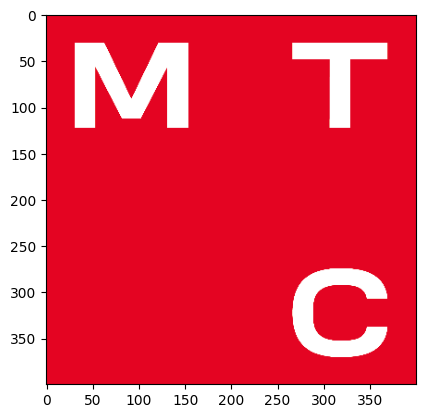

In [3]:
mts_logo: np.ndarray = cv2.imread(img_path / "mts_logo.png", cv2.IMREAD_COLOR)
mts_logo = cv2.cvtColor(mts_logo, cv2.COLOR_BGR2RGB)
mts_logo = cv2.resize(mts_logo, (400, 400))

plt.imshow(mts_logo)
plt.show()

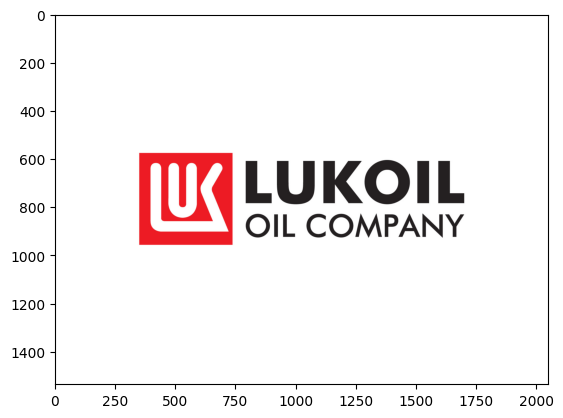

In [4]:
lukoil_logo: np.ndarray = cv2.imread(img_path / "lukoil_logo.jpg", cv2.IMREAD_COLOR)
lukoil_logo = cv2.cvtColor(lukoil_logo, cv2.COLOR_BGR2RGB)

plt.imshow(lukoil_logo)
plt.show()

(1536, 2048, 3)


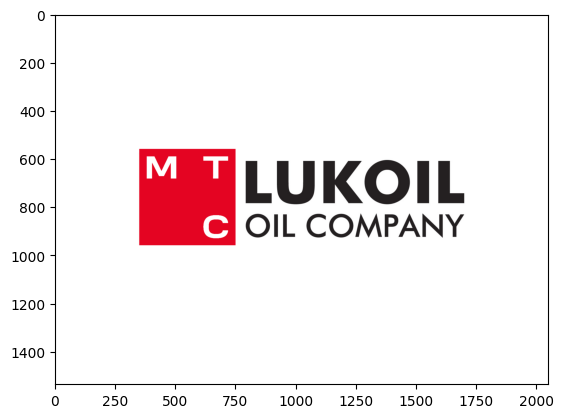

In [5]:
h, w, _ = mts_logo.shape
x_offset, y_offset = 350, 560

mts_on_lukoil_logo = lukoil_logo.copy()
mts_on_lukoil_logo[y_offset : y_offset + h, x_offset : x_offset + w] = mts_logo
print(mts_on_lukoil_logo.shape)

plt.imshow(mts_on_lukoil_logo)
plt.show()

In [6]:
def detect(image: np.ndarray, template: np.ndarray) -> tuple[bool, np.ndarray]:
    image_color = image.copy()
    template_color = template.copy()

    # convert images to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    # init detector
    detector = cv2.SIFT.create()

    # Find keypoints and descriptors with SIFT in both images
    kp_image, des_image = detector.detectAndCompute(image, None)
    kp_template, des_template = detector.detectAndCompute(template, None)

    # Use BFMatcher to find matches between the descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_template, des_image, k=2)

    # FLANN stands for Fast Library for Approximate Nearest Neighbors
    # https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
    # FLANN_INDEX_KDTREE = 1
    # flann = cv2.FlannBasedMatcher(
    #     indexParams=dict(algorithm=FLANN_INDEX_KDTREE, trees=5),
    #     searchParams=dict(checks=50),
    # )
    # matches = flann.knnMatch(des1, des2, k=2)

    # Apply the ratio test to find good matches
    good_matches = []
    ratio_thresh = 0.75
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    # Minimum number of matches needed to find the object
    MIN_MATCH_COUNT = 10

    if len(good_matches) >= MIN_MATCH_COUNT:
        # Extract the locations of matched keypoints in both images
        src_pts = np.float32(
            [kp_template[m.queryIdx].pt for m in good_matches]
        ).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_image[m.trainIdx].pt for m in good_matches]).reshape(
            -1, 1, 2
        )

        # Compute Homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        if M is not None:
            # Get the dimensions of the template image
            h, w = template.shape

            # Get the corner points of the template image and transform them to the scene image
            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(
                -1, 1, 2
            )
            dst = cv2.perspectiveTransform(pts, M)

            # Draw a polygon around the detected region in the scene image
            img_detected = cv2.polylines(
                image_color, [np.int32(dst)], True, (0, 0, 255), 15, shift=0
            )

            # Optionally, display the matching process
            draw_params = dict(
                matchColor=(0, 255, 0),  # Matches in green
                singlePointColor=None,
                matchesMask=mask.ravel().tolist(),  # Draw only inliers
                flags=2,
            )
            img_matches = cv2.drawMatches(
                template_color,
                kp_template,
                image_color,
                kp_image,
                good_matches,
                None,
                **draw_params,
            )

            return True, img_detected, img_matches

    return False, image_color, None

False


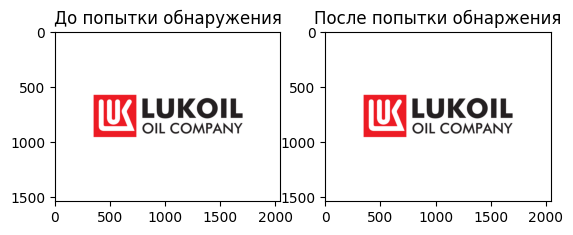

In [7]:
is_detected, detected, matches = detect(lukoil_logo, mts_logo)
print(is_detected)
show_in_row([lukoil_logo, detected], titles=["До попытки обнаружения", "После попытки обнаружения"])

True


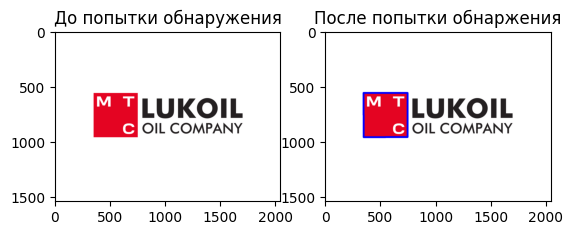

In [9]:
is_detected, detected, matches = detect(mts_on_lukoil_logo, mts_logo)
print(is_detected)
show_in_row([mts_on_lukoil_logo, detected], titles=["До попытки обнаружения", "После попытки обнаружения"])